# Question parser

Parse question into tokens assigned to 4 groups: 
* entities and predicates for the 1st hop (E1 P1)  
* entities and predicates for the 2nd hop (E2 P2)  

Then train a supervised sequence tagging model to extract the mention text spans.

Reference: https://www.depends-on-the-definition.com/sequence-tagging-lstm-crf/

In [3]:
# setup
dataset_name = 'lcquad'
embeddings_choice = 'glove6B100d'

import os
os.chdir('/mpqa_new/KBQA/src')  # path to working directory for saving models

# connect to MongoDB (27017 is the default port) to access the dataset
# sudo service mongod start 
from pymongo import MongoClient


class Mongo_Connector():
    '''
    Wrapper class for some of the pymongo functions: http://api.mongodb.com/python/current/tutorial.html
    '''

    def __init__(self, db_name, col_name):
        # spin up database
        self.mongo_client = MongoClient()
        self.col = self.mongo_client[db_name][col_name]
        
    def get_sample(self, limit=100):
        '''
        Set limit to None to get all docs
        '''
        cursor = self.col.find()
        if limit:
            cursor = cursor.limit(limit)
        return cursor


mongo = Mongo_Connector('kbqa', dataset_name)

## Prepare dataset

Encode questions with IO tokens: E1E2P1P2

In [4]:
limit = None
verbose = False

tags = ['O', 'E', 'P']  # + p_tags
modelname = 'joint'  # joint predicate

import re
from keras.preprocessing.text import text_to_word_sequence

def parse_question(question_o, spans):
    # exclude duplicate spans
    spans = list(set(spans))
    # sort the mention spans into the correct sequence order in the question
    spans.sort(key=lambda tup: tup[0])
    # parse question into mention spans
    cursor_idx = 0
    words, ye = [], []
    for span in spans:
        idx_start, idx_end, tag = span
        # spacing
        space = text_to_word_sequence(question_o[cursor_idx:idx_start])
        words.extend(space)
        ye.extend([''] * len(space))
        # mention
        mention = text_to_word_sequence(question_o[idx_start:idx_end])
        words.extend(mention)
        ye.extend([tag] * len(mention))
        # move cursor to the end of the current annotation span
        cursor_idx = idx_end
    # add the remaining spacing
    space = text_to_word_sequence(question_o[cursor_idx:])
    words.extend(space)
    ye.extend([''] * len(space))
    if verbose:
        print(spans)
        print(words)
        print(ye)
    assert len(words) == len(ye)
    return words, ye


samples = mongo.get_sample(limit=limit)
# iterate over the cursor
questions = []
n_words_distr = []
labels = []
count = 0
question_types = []  # indicate complex questions by number of hops
for doc in samples:
    _complex = 0  # default indicator for simple questions
    # get sample annotations
    question_o = doc['question']
    # get URI distribution across the hops
    e1, p1 = doc['1hop']
    e2, p2 = doc['2hop']
    
    # collect span annotations
    e_spans = []
    p_spans = []
    # fix: some entities are erroneously annotated as predicates
    for e in doc['entity mapping']+doc['predicate mapping']:
        # fix: use labels to find substrings since some of the span indices annotations are incorrect
        matches = re.finditer(re.escape(e['label'].lower()), question_o.lower())
        # pick tag for this mention
        if e['uri'] in e1:
            e_spans.extend([(match.start(), match.end(), 'E1') for match in matches])
        elif e['uri'] in e2:
            e_spans.extend([(match.start(), match.end(), 'E2') for match in matches])
            _complex = 1  # indicate complex question
        elif e['uri'] in p1:
            p_spans.extend([(match.start(), match.end(), 'P1') for match in matches])
        elif e['uri'] in p2:
            p_spans.extend([(match.start(), match.end(), 'P2') for match in matches])
            _complex = 1  # indicate complex question

    if modelname == 'entity':
        words, _y = parse_question(question_o, e_spans)
    elif modelname == 'predicate':
        words, _y = parse_question(question_o, p_spans)
    elif modelname == 'joint':
        words_e, y_e = parse_question(question_o, e_spans)
        words_p, y_p = parse_question(question_o, p_spans)
        if words_e == words_p:
            words = words_e
            _y = []
            for tag_e, tag_p in zip(y_e, y_p):
                if tag_e == '' or tag_p == '':
                    _y.append(tag_e+tag_p)
                else:
                    _y.append(tag_e) # use the entity tag when tags overlap
                
    #     add the sample to the dataset 
    questions.append(words)
    n_words_distr.append(len(words))
    labels.append(_y)
    question_types.append(_complex)
    count += 1

dataset_size = len(questions)
print("Loaded %d %s questions"%(dataset_size, dataset_name))

Using TensorFlow backend.
/mpqa_new/miniconda3/envs/kbqa/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/mpqa_new/miniconda3/envs/kbqa/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/mpqa_new/miniconda3/envs/kbqa/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/mpqa_new/miniconda3/envs/kbqa/l

Loaded 4998 lcquad questions


In [5]:
# show sample question
i = 200
print(questions[i])
print(labels[i])
print(question_types[i])

['was', 'jack', 'ryan', 'a', 'nominee', 'of', 'us', 'senate']
['', 'E1', 'E1', '', 'P1', '', 'E1', 'E1']
1


In [7]:
# load pre-trained word embeddings for question semantic representation
from pymagnitude import *
embeddings_path = "/mpqa_new/KBQA/data/embeddings/"
embeddings = {'glove6B100d': "glove.6B.100d.magnitude"}
vectors = Magnitude(embeddings_path + embeddings[embeddings_choice])

words = list(set([word for q in questions for word in q]))
n_words = len(words)
print("Number of unique words %d"%len(words))
word2idx = {w: i + 1 for i, w in enumerate(words)}

# dataset parameters for training the model
max_len = max(n_words_distr)
print("Maximum question length in the dataset: %d"%max_len)

# prepare data and pad the max length with 0s
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w] for w in s] for s in questions]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)

# encode tags
n_tags = len(tags)
y = [[tags.index(tag[0]) if tag else 0 for tag in s] for s in labels]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=0)
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

# load embeddings into matrix
import math
word_embedding_matrix = np.zeros((n_words+1, vectors.dim))

n_oov = 0

for w in word2idx:
    # get the word vector from the embedding model
    if w in vectors:
        word_vector = vectors.query(w)
    # OOV word
    else:
        n_oov += 1
        word_vector = vectors.query('unk')
    word_embedding_matrix[word2idx[w]] = word_vector

# loaded vector # may be lower than total vocab due to w2v settings
print('%d OOV words'%n_oov)

model_settings = {'embeddings': word_embedding_matrix, 'word2idx': word2idx,
                  'max_len': max_len, 'n_words': n_words, 'n_tags': n_tags, 'emb_dim': vectors.dim}

# save model settings
import pickle as pkl
f = open('%s_%s.pkl'%(dataset_name, embeddings_choice), 'wb')
pkl.dump(model_settings, f, -1)
f.close()
print("Model settings saved.")

Number of unique words 5774
Maximum question length in the dataset: 25
599 OOV words
Model settings saved.


## Mention extraction

In [8]:
# split dataset into training and testing subsets
test_size = 0.1

from sklearn.model_selection import train_test_split
# fix random seed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                    stratify=question_types, random_state=103232)
print("Training on %d samples testing on %d samples" % (len(X_train), len(X_test)))

Training on 4498 samples testing on 500 samples


In [9]:
# bi-LSTM CRF model architecture
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras.optimizers import Adam

def build_model(model_settings):
    # architecture
    input = Input(shape=(model_settings['max_len'],))
    model = Embedding(input_dim=model_settings['n_words']+1, output_dim=model_settings['emb_dim'],
                      weights=[model_settings['embeddings']],
                      input_length=model_settings['max_len'], mask_zero=True, trainable=False)(input)
    model = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.1))(model)  # variational biLSTM
    model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
    crf = CRF(model_settings['n_tags'])  # CRF layer
    out = crf(model)  # output
    model = Model(input, out)
    model.compile(optimizer=Adam(lr=0.0001), loss=crf.loss_function, metrics=[crf.accuracy])
    model.summary()
    return model

# load model settings
import pickle as pkl
with open('%s_%s.pkl'%(dataset_name, embeddings_choice), 'rb') as f:
    model_settings = pkl.load(f)
model = build_model(model_settings)

/mpqa_new/miniconda3/envs/kbqa/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/mpqa_new/miniconda3/envs/kbqa/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 25, 100)           577500    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 25, 100)           60400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 25, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 25, 3)             168       
Total params: 643,118
Trainable params: 65,618
Non-trainable params: 577,500
_________________________________________________________________


In [11]:
# callbacks
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TerminateOnNaN, ModelCheckpoint
cb_redlr = ReduceLROnPlateau(monitor='val_crf_viterbi_accuracy', factor=0.5, patience=3, min_lr=0.0001, verbose=1)
cb_early = EarlyStopping(monitor='val_crf_viterbi_accuracy', min_delta=0, patience=5, verbose=1)
cb_chkpt = ModelCheckpoint('../checkpoints/_'+modelname+'{epoch:02d}-{val_crf_viterbi_accuracy:.2f}.h5', verbose=1, save_best_only=True, save_weights_only=True, period=5)

callbacks_list=[cb_redlr, cb_early, cb_chkpt]

# start training
log = model.fit(X_train, np.array(y_train), batch_size=32, epochs=50,
                callbacks=callbacks_list,
                validation_split=0.1, verbose=1)

Train on 4048 samples, validate on 450 samples
Epoch 1/50
4048/4048 [==============================] - 5s 1ms/step - loss: 2.5652 - crf_viterbi_accuracy: 0.5966 - val_loss: 2.5629 - val_crf_viterbi_accuracy: 0.6109
Epoch 2/50
4048/4048 [==============================] - 6s 1ms/step - loss: 2.5272 - crf_viterbi_accuracy: 0.6279 - val_loss: 2.5222 - val_crf_viterbi_accuracy: 0.6354
Epoch 3/50
4048/4048 [==============================] - 6s 1ms/step - loss: 2.4789 - crf_viterbi_accuracy: 0.6538 - val_loss: 2.4695 - val_crf_viterbi_accuracy: 0.6655
Epoch 4/50
4048/4048 [==============================] - 6s 1ms/step - loss: 2.4175 - crf_viterbi_accuracy: 0.6812 - val_loss: 2.4026 - val_crf_viterbi_accuracy: 0.6888
Epoch 5/50
4048/4048 [==============================] - 6s 1ms/step - loss: 2.3490 - crf_viterbi_accuracy: 0.7090 - val_loss: 2.3355 - val_crf_viterbi_accuracy: 0.7169

Epoch 00005: val_loss improved from inf to 2.33546, saving model to ../checkpoints/_joint05-0.72.h5
Epoch 6/50
4

4048/4048 [==============================] - 5s 1ms/step - loss: 2.0526 - crf_viterbi_accuracy: 0.8485 - val_loss: 2.0919 - val_crf_viterbi_accuracy: 0.8470
Epoch 45/50
4048/4048 [==============================] - 5s 1ms/step - loss: 2.0516 - crf_viterbi_accuracy: 0.8488 - val_loss: 2.0905 - val_crf_viterbi_accuracy: 0.8478

Epoch 00045: val_loss improved from 2.09717 to 2.09051, saving model to ../checkpoints/_joint45-0.85.h5
Epoch 46/50
4048/4048 [==============================] - 6s 1ms/step - loss: 2.0492 - crf_viterbi_accuracy: 0.8503 - val_loss: 2.0897 - val_crf_viterbi_accuracy: 0.8493
Epoch 47/50
4048/4048 [==============================] - 6s 1ms/step - loss: 2.0488 - crf_viterbi_accuracy: 0.8497 - val_loss: 2.0880 - val_crf_viterbi_accuracy: 0.8497
Epoch 48/50
4048/4048 [==============================] - 6s 1ms/step - loss: 2.0475 - crf_viterbi_accuracy: 0.8511 - val_loss: 2.0875 - val_crf_viterbi_accuracy: 0.8487
Epoch 49/50
4048/4048 [==============================] - 6s 1m

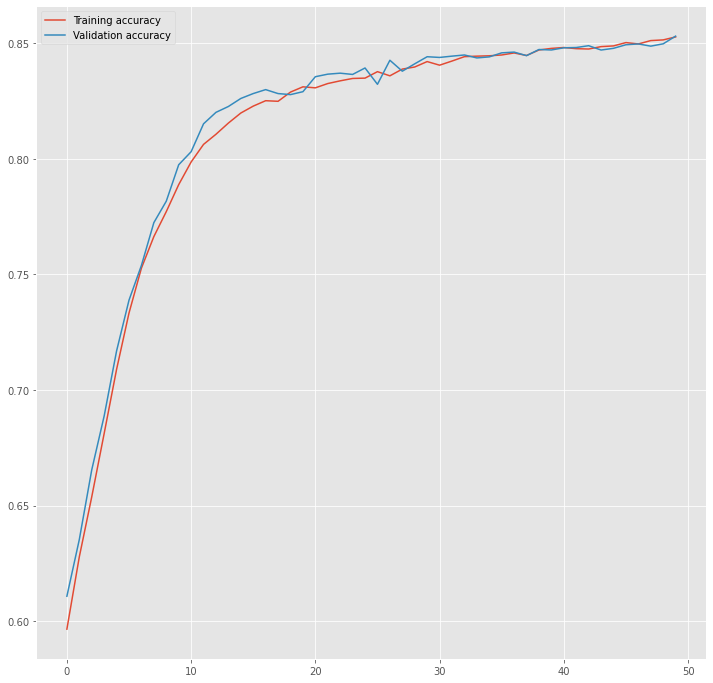

In [12]:
# plot accuracies
import pandas as pd
hist = pd.DataFrame(log.history)
# print(hist)
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["crf_viterbi_accuracy"], label='Training accuracy')
plt.plot(hist["val_crf_viterbi_accuracy"], label='Validation accuracy')
plt.legend()
plt.show()

In [13]:
# evaluate model on the test set
test_pred = model.predict(X_test, verbose=1)

pred_labels = [[tags[np.argmax(p)] for p in pred_i] for pred_i in test_pred]
test_labels = [[tags[np.argmax(p)] for p in pred_i] for pred_i in y_test]

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels, average='weighted')))
print(classification_report(test_labels, pred_labels))

500/500 [==============================] - 1s 1ms/step
F1-score: 83.3%


/mpqa_new/miniconda3/envs/kbqa/lib/python3.6/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: P seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


              precision    recall  f1-score   support

           _       0.82      0.84      0.83      1664

   micro avg       0.82      0.84      0.83      1664
   macro avg       0.82      0.84      0.83      1664
weighted avg       0.82      0.84      0.83      1664



In [14]:
# show sample test prediction
i = 15
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], t, pred))

Word           ||True ||Pred
what           :     2 0
is             :     0 0
a              :     0 0
salthill       :     1 1


In [15]:
# save model
from keras_contrib.utils import save_load_utils
with open('../models/' + modelname + '.json', 'w') as f:
    f.write(model.to_json())

# save weights
save_load_utils.save_all_weights(model, '../models/'+modelname+'.h5')

## Complex questions

In [16]:
modelname = 'complex_questions'

# split dataset into training and testing subsets
test_size = 0.1
from sklearn.model_selection import train_test_split
# fix random seed
X_train, X_test, y_train, y_test = train_test_split(X, question_types, test_size=test_size,
                                                    stratify=question_types, random_state=103232)
print("Training on %d samples testing on %d samples" % (len(X_train), len(X_test)))

Training on 4498 samples testing on 500 samples


In [17]:
# predict question type
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras.optimizers import Adam

def build_model(model_settings):
    # architecture
    input = Input(shape=(model_settings['max_len'],))
    model = Embedding(input_dim=model_settings['n_words']+1, output_dim=model_settings['emb_dim'],
                      weights=[model_settings['embeddings']],
                      input_length=model_settings['max_len'], mask_zero=True, trainable=False)(input)
    model = Bidirectional(LSTM(units=50, return_sequences=False,
                               recurrent_dropout=0.1))(model)  # variational biLSTM
    out = Dense(1, kernel_initializer='normal', activation='sigmoid')(model)  # output
    model = Model(input, out)
    model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# load model settings
import pickle as pkl
with open('%s_%s.pkl'%(dataset_name, embeddings_choice), 'rb') as f:
    model_settings = pkl.load(f)
model = build_model(model_settings)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 25)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 25, 100)           577500    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100)               60400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 638,001
Trainable params: 60,501
Non-trainable params: 577,500
_________________________________________________________________


In [19]:
# callbacks
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TerminateOnNaN, ModelCheckpoint
cb_redlr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3, min_lr=0.0001, verbose=1)
cb_early = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1)
cb_chkpt = ModelCheckpoint('../checkpoints/_'+modelname+'{epoch:02d}-{val_acc:.2f}.h5',
                           verbose=1, save_best_only=True, save_weights_only=True, period=5)

callbacks_list=[cb_redlr, cb_early, cb_chkpt]

# start training: weight the classes proportional
log = model.fit(X_train, np.array(y_train), batch_size=32, epochs=50,
                callbacks=callbacks_list,
                validation_split=0.1, verbose=1, class_weight={0: 1., 1: 9.})

Train on 4048 samples, validate on 450 samples
Epoch 1/50
4048/4048 [==============================] - 4s 1ms/step - loss: 1.6619 - acc: 0.3646 - val_loss: 1.6327 - val_acc: 0.3733
Epoch 2/50
4048/4048 [==============================] - 4s 1ms/step - loss: 1.6484 - acc: 0.3646 - val_loss: 1.6204 - val_acc: 0.3733
Epoch 3/50
4048/4048 [==============================] - 4s 1ms/step - loss: 1.6372 - acc: 0.3646 - val_loss: 1.6073 - val_acc: 0.3733
Epoch 4/50
4048/4048 [==============================] - 4s 1ms/step - loss: 1.6257 - acc: 0.3646 - val_loss: 1.5941 - val_acc: 0.3733
Epoch 5/50
4048/4048 [==============================] - 4s 1ms/step - loss: 1.6114 - acc: 0.3646 - val_loss: 1.5835 - val_acc: 0.3733

Epoch 00005: val_loss improved from inf to 1.58354, saving model to ../checkpoints/_complex_questions05-0.37.h5
Epoch 6/50
4048/4048 [==============================] - 4s 1ms/step - loss: 1.6035 - acc: 0.3646 - val_loss: 1.5766 - val_acc: 0.3733
Epoch 00006: early stopping


In [20]:
# evaluate
# np.set_printoptions(precision=4, suppress=True)
# eval_results = model.evaluate(X_test, y_test, verbose=0) 
# print("\nLoss, accuracy on test data: ")
# print("%0.4f %0.2f%%" % (eval_results[0], \
#   eval_results[1]*100))

# evaluate model on the test set
test_pred = model.predict(X_test, verbose=1)
y_pred = [1 if pred > 0.5 else 0 for pred in test_pred]
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
print("F1-score: {:.1%}".format(f1_score(y_test, y_pred, average='weighted')))
print(classification_report(y_test, y_pred))

500/500 [==============================] - 1s 1ms/step
F1-score: 19.6%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       317
           1       0.37      1.00      0.54       183

    accuracy                           0.37       500
   macro avg       0.18      0.50      0.27       500
weighted avg       0.13      0.37      0.20       500



/mpqa_new/miniconda3/envs/kbqa/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mpqa_new/miniconda3/envs/kbqa/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mpqa_new/miniconda3/envs/kbqa/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# show sample test prediction
i = 30
p = model.predict(np.array([X_test[i]]))
q = " ".join([words[w-1] for w in X_test[i] if w != 0])
print(q)
print("%.2f"%p[0][0])

who is the authority of maine school of science and mathematics
0.85
